In [3]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

!pip install scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

from google.colab import drive




In [5]:
drive.mount('/content/drive')
path_to_csv = '/content/drive/My Drive/Colab Notebooks/ML/PSO.csv'

df = pd.read_csv(path_to_csv, sep = ",",decimal =".")


Mounted at /content/drive


In [6]:
df.drop('Symbol', axis=1, inplace=True)
#df['Date'] = pd.to_datetime(df.Period , format = '%d.%m.%Y')
df['Date'] = pd.to_datetime(df.Date , format = '%d-%b-%Y')
df = df.set_index('Date')

In [7]:
#Блок предбоработки временного ряда
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2003-01-01,213.5,215.10,207.00,208.00,29005800
2003-01-02,208.0,217.00,208.00,215.65,48945500
2003-01-03,218.0,219.50,215.75,219.40,32286100
2003-01-06,219.0,226.25,216.90,225.30,51049100
2003-01-07,227.0,232.95,226.05,228.95,53225400


In [8]:
df.describe()

,Open,High,Low,Close,Volume
count,4065.000000,4065.000000,4065.000000,4065.000000,4.065000e+03
mean,315.900910,319.737875,311.841009,315.402625,3.346508e+06
std,78.028117,78.855480,77.038479,77.848331,6.595363e+06
min,94.000000,100.000000,92.100000,96.000000,1.000000e+02
25%,259.400000,261.500000,256.550000,258.840000,4.603000e+05
50%,310.000000,314.300000,306.010000,309.340000,1.106500e+06
75%,375.000000,380.000000,370.500000,375.000000,2.713600e+06
max,537.000000,544.900000,530.400000,539.700000,6.570180e+07


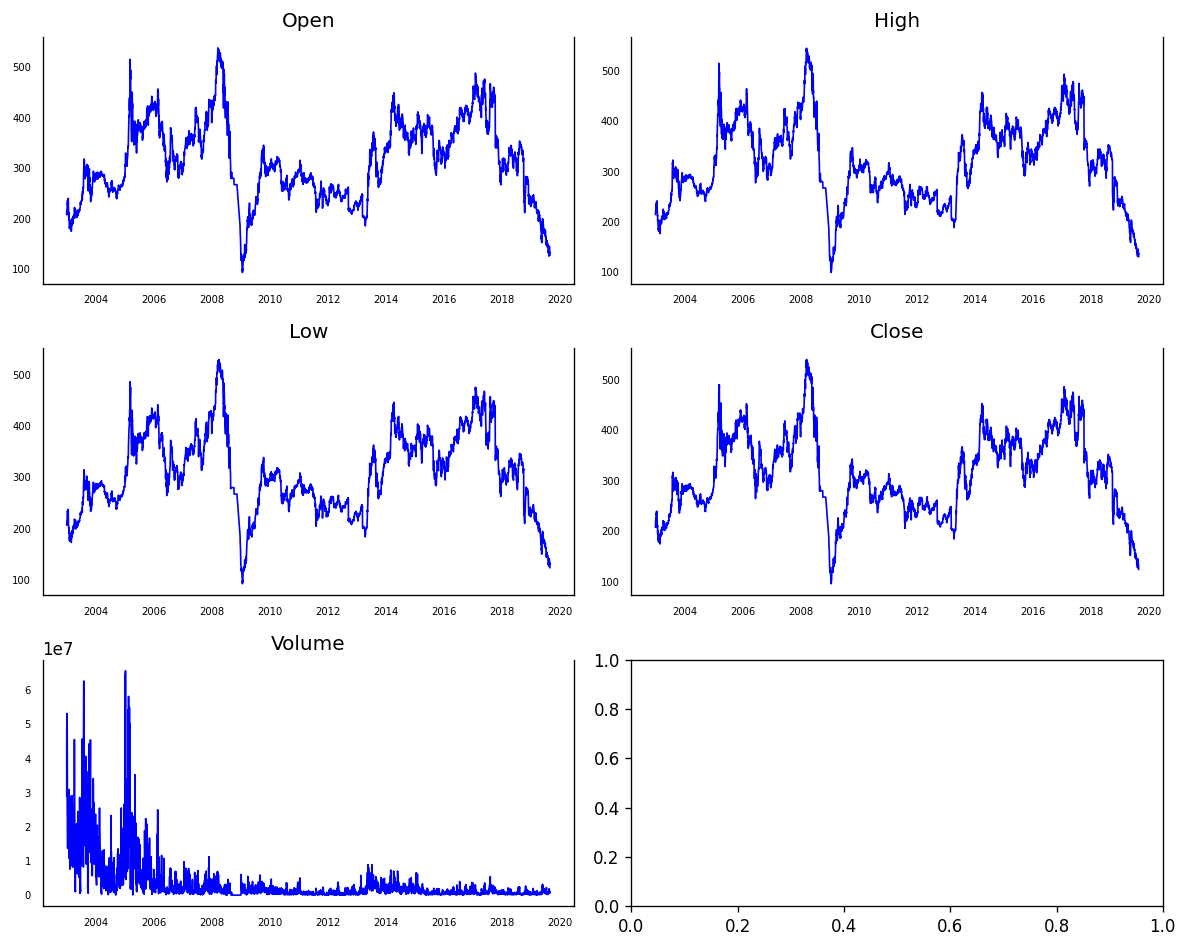

In [9]:
#Смотрим на графики считанных временных рядов.

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    if i < 5:
        data = df[df.columns[i]]
        ax.plot(data, color='blue', linewidth=1)
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
plt.tight_layout()

In [10]:
#Проверка на пропуски
skips = df.isnull().sum()
skips

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [11]:
df.shape

(4065, 5)

In [ ]:
#Заполнение пропущенных значений ближайшими соседними наблюдениями
#df.ffill(inplace=True)

In [12]:
#Проверяем наши ряды на стационарность.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 9), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [13]:
train = df[:int(0.8 * (len(data)))]
test = df[int(0.8 * (len(data))):]

In [14]:
print(train.shape)

(3252, 5)


In [15]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1155
 No. Lags Chosen       = 24
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.025424599. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9764
 No. Lags Chosen       = 14
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.037156677. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

In [16]:
# если нестационарный, то удаляем тренд (помните дифференцирование ?) и опять проверяеми
# 1st difference
df_differenced = train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.5526
 No. Lags Chosen       = 23
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.9108
 No. Lags Chosen       = 8
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [17]:
#VAR
#Для VAR модели важен порядок - число, которое характеризует набор предыдущих значений,
#которые модель использует для предсказаний следующих значений.

#Подберём его с помощью специального метода и выбирем то,
#где лучше всего метрики AIC (Akaike Information Criterion),
#BIC (Bayesian Information Criterion), FPE (Final Prediction Error) и HQC (Hannan-Quinn Criterion).
model = VAR(train)
x = model.select_order(maxlags=100)
x.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,47.29,47.30,3.457e+20,47.30
1,39.54,39.60,1.492e+17,39.56
2,39.36,39.47,1.243e+17,39.40
3,39.28,39.43*,1.143e+17,39.33*
4,39.27,39.47,1.135e+17,39.34
5,39.25,39.50,1.117e+17,39.34
6,39.23,39.53,1.094e+17,39.34
7,39.22,39.57,1.081e+17,39.35
8,39.23,39.62,1.086e+17,39.37
9,39.22,39.66,1.076e+17,39.38


In [18]:
#Выбираем наилучшее число - 18 и обучаем модель.

model_fitted = model.fit(18)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Mar, 2024
Time:                     17:56:20
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    40.0662
Nobs:                     3234.00    HQIC:                   39.5171
Log likelihood:          -85892.7    FPE:                1.06895e+17
AIC:                      39.2105    Det(Omega_mle):     9.30459e+16
--------------------------------------------------------------------
Results for equation Open
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.355297         0.263652            1.348           0.178
L1.Open            0.044007         0.027691            1.589           0.112
L1.High           -0.008646         0.028951           -0.299           0

In [19]:
#Готовим данные для проверки предсказаний.

def create_dataset(test, in_seq, for_len, step):
    testX = []
    testY = []
    for i in range(0, len(test) - for_len - in_seq, step):
        testX.append(test[i:(i + in_seq)].to_numpy())
        testY.append(test[(i + in_seq):(i + in_seq + for_len)].to_numpy())
    return testX, testY


In [20]:
X_test, Y_test = create_dataset(test, 18, 1, 1)
X_train, Y_train = create_dataset(train, 18, 1, 1)

In [21]:
predictions = []
for x in X_test:
    predictions += [model_fitted.forecast(y=x,steps=1)]
predictions = np.array(predictions)
Y_test = np.array(Y_test)
print(predictions.shape)

(794, 1, 5)


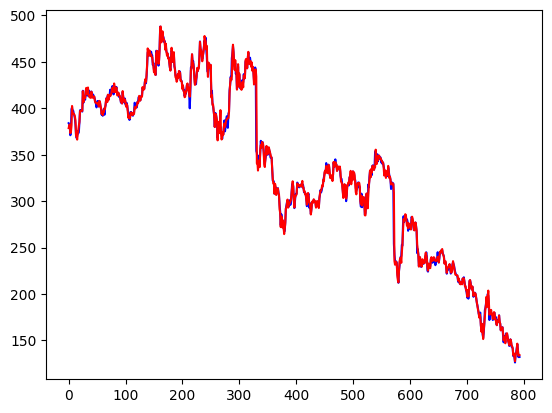

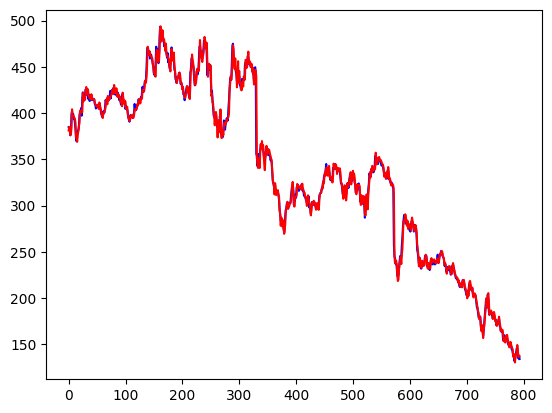

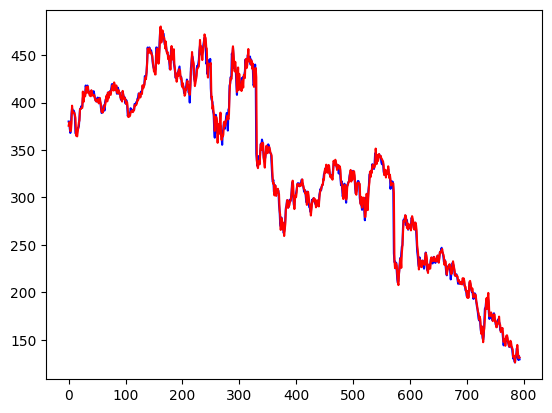

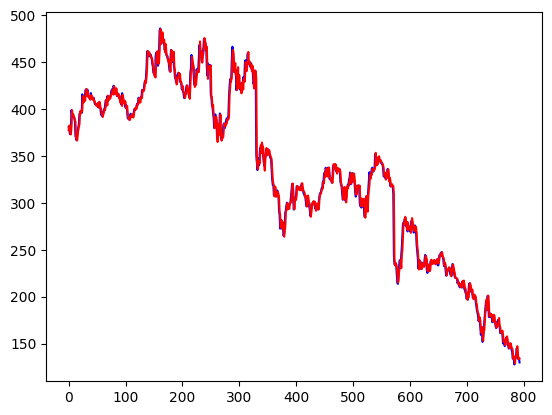

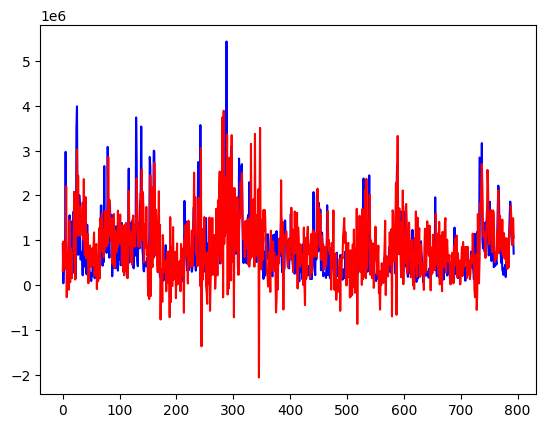

In [22]:
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    plt.plot(Y_test[:,:,i], color="b", label="original")
    plt.plot(predictions[:,:,i], color="r", label="predicted")
    plt.show()

In [23]:
#Считаем метрики по предсказаниям

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    r2 = r2_score(actual, forecast)
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'R^2':r2})

In [24]:
cols = test.columns.to_list()

for vi in range(len(cols)):
    print(f'Forecast Accuracy of: {cols[vi]}')
    n1 = f"{cols[vi]}_forecast"
    accuracy_prod = forecast_accuracy(predictions[:,:,vi], Y_test[:,:,vi])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))
    print('')

Forecast Accuracy of: Open
mape :  0.0062
me :  0.048
mae :  1.9392
mpe :  0.0004
rmse :  4.4157
R^2 :  0.9977

Forecast Accuracy of: High
mape :  0.0104
me :  0.0894
mae :  3.3508
mpe :  0.0006
rmse :  5.5651
R^2 :  0.9964

Forecast Accuracy of: Low
mape :  0.0113
me :  0.2936
mae :  3.475
mpe :  0.0017
rmse :  5.7385
R^2 :  0.9961

Forecast Accuracy of: Close
mape :  0.0151
me :  0.1525
mae :  4.6784
mpe :  0.0015
rmse :  7.1167
R^2 :  0.994

Forecast Accuracy of: Volume
mape :  1.2661
me :  96341.2257
mae :  595643.1763
mpe :  0.704
rmse :  795123.4112
R^2 :  -0.4824



In [ ]:
#Метрики предсказаний, в целом, хорошие: mape, me, mpe для всех рядов (кроме последнего) почти < 1.
#R^2 же показал очень хороший результат (для всех, кроме последнего, вообще 0.95+).
#MAE показал результат хуже от 2 до 5(кроме последнего)

In [25]:
test_size=int(len(df) * 0.2)
test_size

813

In [26]:
train_df = df[:-test_size]
test_df = df[-test_size:]

print(train_df.shape)
print(test_df.shape)

(3252, 5)
(813, 5)


In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [28]:
train_df_scaled

array([[0.26975169, 0.25870982, 0.26214921, 0.25242281, 0.44147564],
       [0.25733634, 0.26298045, 0.26443076, 0.26966419, 0.74496398],
       [0.27990971, 0.26859969, 0.28211271, 0.27811584, 0.49140281],
       ...,
       [0.62076749, 0.60908069, 0.62833676, 0.61751183, 0.00470155],
       [0.62866817, 0.62407283, 0.63529546, 0.62765382, 0.02396894],
       [0.63882619, 0.63358058, 0.65001141, 0.63745774, 0.01967681]])

In [29]:
test_df_scaled

array([[0.64221219, 0.62823106, 0.64430755, 0.63322064, 0.0046011 ],
       [0.64334086, 0.62935491, 0.64772987, 0.63757043, 0.00619923],
       [0.64785553, 0.64059339, 0.65457449, 0.63921569, 0.01115953],
       ...,
       [0.09029345, 0.08574961, 0.09331508, 0.08564345, 0.01718525],
       [0.08634312, 0.07687121, 0.08532968, 0.07676358, 0.01072575],
       [0.07697517, 0.07077995, 0.07232489, 0.06432274, 0.00915806]])

In [30]:
#Создаём датасет из данных.
n_past=18
def createXY(dataset, n_past, col_to_forecast = 0):
    dataX = []
    dataY = []
    for i in range(0, len(dataset) - n_past):
            dataX.append(dataset[i:i + n_past, 0:dataset.shape[1]])
            dataY.append(dataset[i + n_past, col_to_forecast])
    return np.array(dataX),np.array(dataY)

In [31]:
X_train, Y_train = createXY(train_df_scaled, n_past, 2)
X_test, Y_test = createXY(test_df_scaled, n_past, 2)

In [32]:
X_train.shape

(3234, 18, 5)

In [33]:
X_test.shape

(795, 18, 5)

In [37]:
def build_model(optimizer="adam", npas=n_past, icol=5):
    grid_model = Sequential()
    grid_model.add(LSTM(20 + n_past, input_shape=(n_past, icol)))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return grid_model

grid_model = KerasRegressor(model=build_model,verbose=1, fit__validation_data=(X_test,Y_test))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }


grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2,
                            scoring='neg_mean_squared_error')

In [38]:
# обучаем  и ищем новые параметры
grid_search = grid_search.fit(X_train, Y_train)

Epoch 1/8
102/102 [==============================] - 9s 40ms/step - loss: 0.0156 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 2/8
102/102 [==============================] - 2s 19ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 3/8
102/102 [==============================] - 2s 15ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 9.7312e-04 - val_accuracy: 0.0000e+00
Epoch 4/8
102/102 [==============================] - 2s 17ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 5/8
102/102 [==============================] - 2s 16ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 6/8
102/102 [==============================] - 1s 11ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 7.5314e-04 - val_accuracy: 0.0000e+00
Epoch 7/8
102/102 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy:

In [39]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

In [40]:
# заполняем лучшими параметрами
my_model=grid_search.best_estimator_.model
my_model

<function __main__.build_model(optimizer='adam', npas=18, icol=5)>

In [41]:
prediction=grid_search.best_estimator_.predict(X_test)

print(f"prediction {prediction} \n")
print(f"Prediction Shape {prediction.shape}")

50/50 [==============================] - 1s 4ms/step
prediction [0.64945304 0.65138537 0.65162617 0.64702445 0.64039767 0.6409958
 0.65649223 0.66778946 0.67328733 0.67725915 0.6785985  0.67753106
 0.673262   0.659159   0.6455935  0.6339795  0.62953883 0.6307884
 0.632269   0.63630176 0.64896727 0.6625894  0.67209244 0.68070996
 0.6841171  0.6949058  0.70613873 0.71069837 0.7148509  0.7162784
 0.7194534  0.7270459  0.72858566 0.7283273  0.7315394  0.7306387
 0.72742355 0.72603655 0.7225728  0.7201446  0.721414   0.72197044
 0.72051734 0.71946245 0.71890485 0.7192119  0.7174699  0.71352756
 0.70920557 0.70555764 0.70234776 0.701567   0.7027558  0.7010302
 0.7017418  0.7034324  0.7027359  0.69948083 0.6928852  0.6860959
 0.6810656  0.6794189  0.6806773  0.68323547 0.68257016 0.6881039
 0.69581664 0.7020136  0.70741683 0.71354246 0.7150497  0.71617156
 0.71885425 0.7200421  0.7243186  0.7242763  0.72792256 0.7330201
 0.73579925 0.73501927 0.7375523  0.73784006 0.7368067  0.7342183
 0.7355

In [42]:
pred = prediction.reshape(-1, 1)

prediction_copies_array = np.repeat(pred,5, axis=-1)
prediction_copies_array.shape

(795, 5)

In [43]:
cfs = len(df.columns)

prediction=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction_copies_array),cfs)))[:,0]
prediction

array([381.7077 , 382.56372, 382.67038, 380.63184, 377.69617, 377.96115,
       384.82605, 389.83072, 392.2663 , 394.0258 , 394.61914, 394.14627,
       392.25507, 386.00745, 379.99792, 374.8529 , 372.8857 , 373.43924,
       374.09518, 375.88168, 381.4925 , 387.5271 , 391.73694, 395.5545 ,
       397.06387, 401.84326, 406.81946, 408.8394 , 410.67896, 411.3113 ,
       412.71786, 416.08133, 416.76346, 416.649  , 418.07196, 417.67294,
       416.24863, 415.6342 , 414.09976, 413.02408, 413.58643, 413.83292,
       413.18918, 412.72186, 412.47485, 412.61087, 411.83914, 410.0927 ,
       408.17807, 406.56204, 405.14005, 404.7942 , 405.32083, 404.55637,
       404.8716 , 405.62054, 405.312  , 403.87   , 400.94815, 397.9405 ,
       395.71207, 394.98257, 395.54004, 396.6733 , 396.37857, 398.83005,
       402.24677, 404.99203, 407.38565, 410.0993 , 410.767  , 411.264  ,
       412.45242, 412.97867, 414.87314, 414.8544 , 416.4697 , 418.7279 ,
       419.95908, 419.61353, 420.73566, 420.86316, 

In [44]:
original_copies_array = np.repeat(Y_test.reshape(-1, 1),cfs, axis=-1)
original_copies_array.shape

(795, 5)

In [45]:
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(Y_test),cfs)))[:,0]

In [46]:
print(f"Pred Values-- {prediction}\n\n")
print(f"Original Values-- {original}")

Pred Values-- [381.7077  382.56372 382.67038 380.63184 377.69617 377.96115 384.82605
 389.83072 392.2663  394.0258  394.61914 394.14627 392.25507 386.00745
 379.99792 374.8529  372.8857  373.43924 374.09518 375.88168 381.4925
 387.5271  391.73694 395.5545  397.06387 401.84326 406.81946 408.8394
 410.67896 411.3113  412.71786 416.08133 416.76346 416.649   418.07196
 417.67294 416.24863 415.6342  414.09976 413.02408 413.58643 413.83292
 413.18918 412.72186 412.47485 412.61087 411.83914 410.0927  408.17807
 406.56204 405.14005 404.7942  405.32083 404.55637 404.8716  405.62054
 405.312   403.87    400.94815 397.9405  395.71207 394.98257 395.54004
 396.6733  396.37857 398.83005 402.24677 404.99203 407.38565 410.0993
 410.767   411.264   412.45242 412.97867 414.87314 414.8544  416.4697
 418.7279  419.95908 419.61353 420.73566 420.86316 420.40536 419.2587
 419.84988 418.74573 416.82962 417.11777 416.2152  415.49692 413.74628
 412.5313  411.0109  408.65274 407.02664 407.94495 409.96933 410.253

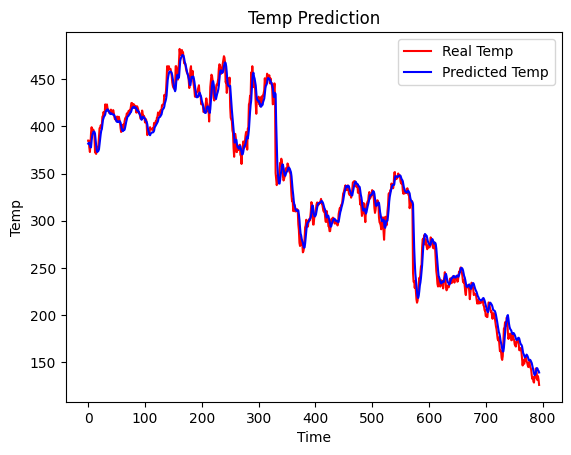

In [48]:
plt.plot(original, color = 'red', label = 'Real Temp')
plt.plot(prediction, color = 'blue', label = 'Predicted Temp')
plt.title('Temp Prediction')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

In [49]:
print('LSTM metrics:')
metrics = forecast_accuracy(prediction, original)
metric_names = metrics.keys()
for metric in metric_names:
    print(metric, '=', metrics[metric])

LSTM metrics:
mape = 0.02347374928077431
me = 1.3204569938933726
mae = 6.83026908340715
mpe = 0.008385644751977887
rmse = 9.88012952218184
R^2 = 0.9886742649698462


## Заключение
Forecast Accuracy of: High
mape :  0.0104
me :  0.0894
mae :  3.3508
mpe :  0.0006
rmse :  5.5651
R^2 :  0.9964

LSTM metrics:
mape = 0.0234
me = 1.3204
mae = 6.8302
mpe = 0.0083
rmse = 9.8801
R^2 = 0.9886

Видно, что классический алгоритм показал лучше результаты, чем нейросеть.

Возможно причиной неудачи нейросети являетя малое количество эпох обучения (8), и для качественной работы нейросети требуется более длительное обучение. Хотя когда искали лучшие параметры, было выбрано меньшее количество эпох. Возможно нужно изменить архитектуру.


Можно сделать вывод, что при отсуствии времении и достаточных вычислительных ресурсов, классические алгоритмы имеют преймущество перед нейросетями. Несмотря на это, мы знаем, что нейросети имеют большую апроксимирующую способность, поэтому при достаточно большом количестве имеющегося времени и вычислительных ресурсов, нейросеть покажет более лучшие результаты, чем класический алгоритм VAR.
